In [1]:
from google.colab import files
uploaded = files.upload()  # Click "Choose Files" and select your products.csv

Saving MSFT_stock_features.csv to MSFT_stock_features.csv


In [3]:
import pandas as pd
import io

# Read the uploaded file
df = pd.read_csv(io.BytesIO(uploaded['MSFT_stock_features.csv']))
print(df)

# Or if you just want to save it first:
with open('MSFT_stock_features.csv', 'wb') as f:
    f.write(uploaded['MSFT_stock_features.csv'])

df = pd.read_csv('MSFT_stock_features.csv')
print(df)

           Date       Close        High         Low        Open      Volume  \
0    2020-10-15  211.349106  212.022618  207.837196  208.885967  22733100.0   
1    2020-10-16  211.349106  213.879589  211.021973  211.820557  26057900.0   
2    2020-10-19  206.114944  213.889238  205.633862  212.080363  27625800.0   
3    2020-10-20  206.528656  209.145745  205.027681  207.635154  22753500.0   
4    2020-10-21  206.673004  208.712789  205.056560  205.056560  22724900.0   
..          ...         ...         ...         ...         ...         ...   
802  2023-12-22  371.055664  371.650025  369.203263  370.164138  17091100.0   
803  2023-12-26  371.134949  373.393496  369.985859  371.471746  12673100.0   
804  2023-12-27  370.550537  371.531213  369.302382  370.174108  14905400.0   
805  2023-12-28  371.749115  372.918006  370.639658  371.838265  14327000.0   
806  2023-12-29  372.501953  373.611411  369.966042  372.462321  18723000.0   

           MA10        MA50       MA100       MA200

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Load the enhanced dataset
def load_enhanced_data(ticker="MSFT"):
    df = pd.read_csv(f"{ticker}_stock_features.csv")
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is datetime
    df.set_index('Date', inplace=True)
    return df

ticker = "MSFT"
data = load_enhanced_data(ticker)
print(data.head())  # Verify all features are loaded

                 Close        High         Low        Open      Volume  \
Date                                                                     
2020-10-15  211.349106  212.022618  207.837196  208.885967  22733100.0   
2020-10-16  211.349106  213.879589  211.021973  211.820557  26057900.0   
2020-10-19  206.114944  213.889238  205.633862  212.080363  27625800.0   
2020-10-20  206.528656  209.145745  205.027681  207.635154  22753500.0   
2020-10-21  206.673004  208.712789  205.056560  205.056560  22724900.0   

                  MA10        MA50       MA100       MA200        RSI  \
Date                                                                    
2020-10-15  206.238095  203.882420  197.775833  179.449973  63.430064   
2020-10-16  207.534129  203.956154  198.144231  179.740103  62.034775   
2020-10-19  207.903598  203.999498  198.464222  180.013607  57.611569   
2020-10-20  208.744530  204.132319  198.770593  180.287222  55.013906   
2020-10-21  209.222725  204.361515  199.082

In [6]:
# Select features and target
features = ['Close', 'MA100', 'RSI', 'Norm_Volume', 'Bollinger_Upper', 'Bollinger_Lower']
data = data[features]  # Keep only selected features

In [7]:
def min_max_scaling(data):
    """Scale data to [0, 1] range and return scaled data + min/max values"""
    min_val = np.min(data)
    max_val = np.max(data)
    # Handle case where all values are identical (avoid division by zero)
    if max_val == min_val:
        return np.zeros_like(data), min_val, max_val
    return (data - min_val) / (max_val - min_val), min_val, max_val

In [8]:
def scale_features(df):
    """Scale each feature column independently"""
    scaled_data = {}
    scalers = {}  # To store min/max for each feature

    for col in df.columns:
        if col == 'Close':  # Our target
            scaled_values, min_val, max_val = min_max_scaling(df[col].values)
            scalers['target'] = (min_val, max_val)
        else:
            scaled_values, min_val, max_val = min_max_scaling(df[col].values)
            scalers[col] = (min_val, max_val)

        scaled_data[col] = scaled_values

    return pd.DataFrame(scaled_data), scalers

# Scale all features
scaled_data, scalers = scale_features(data)

# Split into train/test (keeping temporal order)
split_ratio = 0.8
split_index = int(len(scaled_data) * split_ratio)
train_data = scaled_data.iloc[:split_index]
test_data = scaled_data.iloc[split_index:]

In [9]:
def create_sequences_multi(data, seq_length=50, target_col='Close'):
    """Create sequences from multiple features"""
    X, y = [], []
    data_values = data.values  # Convert to numpy array

    for i in range(len(data) - seq_length):
        # All features for the sequence
        X.append(data_values[i:i+seq_length, :])
        # Only the Close price as target
        y.append(data_values[i+seq_length, data.columns.get_loc(target_col)])

    return np.array(X), np.array(y)

# Create sequences
seq_length = 50
X_train, y_train = create_sequences_multi(train_data, seq_length)
X_test, y_test = create_sequences_multi(test_data, seq_length)

# Note: No need to reshape since we already have 3D (samples, timesteps, features)
print(f"Training shapes - X: {X_train.shape}, y: {y_train.shape}")
print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

Training shapes - X: (595, 50, 6), y: (595,)
Test shapes - X: (112, 50, 6), y: (112,)


In [10]:
# Add Adam optimizer support in LSTM class

class LSTM:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 1  # time step for Adam

        # Initialize weights
        self.Wf = np.random.randn(hidden_dim, hidden_dim + input_dim) * 0.01
        self.bf = np.zeros((hidden_dim, 1))
        self.Wi = np.random.randn(hidden_dim, hidden_dim + input_dim) * 0.01
        self.bi = np.zeros((hidden_dim, 1))
        self.Wc = np.random.randn(hidden_dim, hidden_dim + input_dim) * 0.01
        self.bc = np.zeros((hidden_dim, 1))
        self.Wo = np.random.randn(hidden_dim, hidden_dim + input_dim) * 0.01
        self.bo = np.zeros((hidden_dim, 1))
        self.Wy = np.random.randn(output_dim, hidden_dim) * 0.01
        self.by = np.zeros((output_dim, 1))

        # Initialize Adam moment estimates
        self._init_adam_params()

    def _init_adam_params(self):
        self.m = {}
        self.v = {}
        for param_name in ['Wf', 'Wi', 'Wc', 'Wo', 'Wy', 'bf', 'bi', 'bc', 'bo', 'by']:
            param = getattr(self, param_name)
            self.m[param_name] = np.zeros_like(param)
            self.v[param_name] = np.zeros_like(param)

    def sigmoid(self, x): return 1 / (1 + np.exp(-x))
    def dsigmoid(self, x): return x * (1 - x)
    def tanh(self, x): return np.tanh(x)
    def dtanh(self, x): return 1 - x ** 2

    def forward(self, x_seq, h=None, c=None):
        if h is None: h = np.zeros((self.hidden_dim, 1))
        if c is None: c = np.zeros((self.hidden_dim, 1))
        self.caches = []

        for x in x_seq:
            x = x.reshape(self.input_dim, 1)
            concat = np.vstack((h, x))

            ft = self.sigmoid(np.dot(self.Wf, concat) + self.bf)
            it = self.sigmoid(np.dot(self.Wi, concat) + self.bi)
            c_tilde = self.tanh(np.dot(self.Wc, concat) + self.bc)
            c = ft * c + it * c_tilde
            ot = self.sigmoid(np.dot(self.Wo, concat) + self.bo)
            h = ot * self.tanh(c)

            self.caches.append((h, c, ft, it, c_tilde, ot, concat))

        y_hat = np.dot(self.Wy, h) + self.by
        return y_hat, h, c

    def backward(self, x_seq, y_hat, y_true):
        dh_next = np.zeros((self.hidden_dim, 1))
        dc_next = np.zeros((self.hidden_dim, 1))

        grads = {
            'Wf': np.zeros_like(self.Wf), 'Wi': np.zeros_like(self.Wi),
            'Wc': np.zeros_like(self.Wc), 'Wo': np.zeros_like(self.Wo),
            'Wy': np.zeros_like(self.Wy),
            'bf': np.zeros_like(self.bf), 'bi': np.zeros_like(self.bi),
            'bc': np.zeros_like(self.bc), 'bo': np.zeros_like(self.bo),
            'by': np.zeros_like(self.by)
        }

        dy = y_hat - y_true
        grads['Wy'] += np.dot(dy, self.caches[-1][0].T)
        grads['by'] += dy

        dh = np.dot(self.Wy.T, dy) + dh_next

        for t in reversed(range(len(x_seq))):
            h, c, ft, it, c_tilde, ot, concat = self.caches[t]
            c_prev = self.caches[t - 1][1] if t > 0 else np.zeros_like(c)

            do = dh * self.tanh(c)
            do_raw = do * self.dsigmoid(ot)

            dc = dh * ot * self.dtanh(self.tanh(c)) + dc_next
            dc_tilde = dc * it
            dc_tilde_raw = dc_tilde * self.dtanh(c_tilde)

            di = dc * c_tilde
            di_raw = di * self.dsigmoid(it)

            df = dc * c_prev
            df_raw = df * self.dsigmoid(ft)

            grads['Wf'] += np.dot(df_raw, concat.T)
            grads['Wi'] += np.dot(di_raw, concat.T)
            grads['Wc'] += np.dot(dc_tilde_raw, concat.T)
            grads['Wo'] += np.dot(do_raw, concat.T)

            grads['bf'] += df_raw
            grads['bi'] += di_raw
            grads['bc'] += dc_tilde_raw
            grads['bo'] += do_raw

            dconcat = (np.dot(self.Wf.T, df_raw) +
                       np.dot(self.Wi.T, di_raw) +
                       np.dot(self.Wc.T, dc_tilde_raw) +
                       np.dot(self.Wo.T, do_raw))

            dh = dconcat[:self.hidden_dim, :]
            dc_next = dc * ft

        self._apply_adam(grads)
        self.t += 1  # Increment timestep

    def _apply_adam(self, grads):
        for param_name in grads:
            grad = grads[param_name]
            self.m[param_name] = self.beta1 * self.m[param_name] + (1 - self.beta1) * grad
            self.v[param_name] = self.beta2 * self.v[param_name] + (1 - self.beta2) * (grad ** 2)

            m_hat = self.m[param_name] / (1 - self.beta1 ** self.t)
            v_hat = self.v[param_name] / (1 - self.beta2 ** self.t)

            param = getattr(self, param_name)
            param -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
            setattr(self, param_name, param)

    def train(self, X_train, y_train, epochs=10, batch_size=32):
        for epoch in range(epochs):
            total_loss = 0
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)

            for i in range(0, len(X_train), batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_loss = 0
                batch_grads = []

                for j in batch_indices:
                    x_seq = X_train[j]
                    y_true = y_train[j].reshape(self.output_dim, 1)

                    y_hat, _, _ = self.forward(x_seq)
                    loss = np.mean((y_hat - y_true) ** 2)
                    batch_loss += loss

                    self.backward(x_seq, y_hat, y_true)

                total_loss += batch_loss

            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.6f}")


In [11]:
num_features = len(features)
lstm = LSTM(input_dim=num_features, hidden_dim=128, output_dim=1, learning_rate=0.001)
lstm.train(X_train, y_train, epochs=150, batch_size=32)

Epoch 1/150, Loss: 6.497000
Epoch 2/150, Loss: 1.487863
Epoch 3/150, Loss: 1.070105
Epoch 4/150, Loss: 0.938095
Epoch 5/150, Loss: 0.806968
Epoch 6/150, Loss: 0.769891
Epoch 7/150, Loss: 0.714707
Epoch 8/150, Loss: 0.659416
Epoch 9/150, Loss: 0.714355
Epoch 10/150, Loss: 0.575261
Epoch 11/150, Loss: 0.630836
Epoch 12/150, Loss: 0.610851
Epoch 13/150, Loss: 0.597130
Epoch 14/150, Loss: 0.579015
Epoch 15/150, Loss: 0.548061
Epoch 16/150, Loss: 0.537844
Epoch 17/150, Loss: 0.555324
Epoch 18/150, Loss: 0.527972
Epoch 19/150, Loss: 0.518657
Epoch 20/150, Loss: 0.513781
Epoch 21/150, Loss: 0.487687
Epoch 22/150, Loss: 0.491988
Epoch 23/150, Loss: 0.476129
Epoch 24/150, Loss: 0.474527
Epoch 25/150, Loss: 0.463828
Epoch 26/150, Loss: 0.474190
Epoch 27/150, Loss: 0.471110
Epoch 28/150, Loss: 0.487111
Epoch 29/150, Loss: 0.463411
Epoch 30/150, Loss: 0.451433
Epoch 31/150, Loss: 0.468907
Epoch 32/150, Loss: 0.470008
Epoch 33/150, Loss: 0.458629
Epoch 34/150, Loss: 0.505501
Epoch 35/150, Loss: 0.4

In [12]:
def predict_multi(lstm, X_test, scalers):
    predictions = []

    for i in range(len(X_test)):
        x_seq = X_test[i]
        # Reinitialize h and c for stateless predictions
        h_prev = np.zeros((lstm.hidden_dim, 1))
        c_prev = np.zeros((lstm.hidden_dim, 1))
        y_pred, _, _ = lstm.forward(x_seq, h_prev, c_prev)
        predictions.append(y_pred.flatten()[0])

    # Inverse scale predictions
    min_target, max_target = scalers['target']
    predictions = np.array(predictions) * (max_target - min_target) + min_target
    return predictions


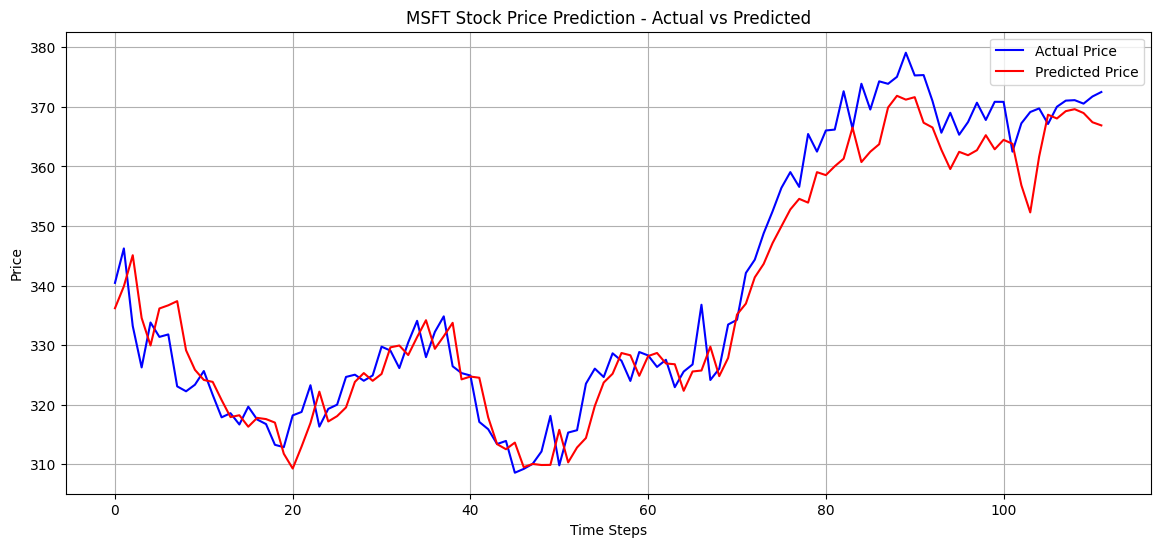

In [13]:
# Inverse transform y_test
min_target, max_target = scalers['target']
y_test_actual = y_test * (max_target - min_target) + min_target

# Generate predictions
predictions = predict_multi(lstm, X_test, scalers)

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price', color='red')
plt.title(f"{ticker} Stock Price Prediction - Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Align the dates with predictions (considering sequence length offset)
test_dates = data.index[split_index + seq_length:]  # since we lose 'seq_length' rows when creating sequences

# Create a DataFrame with Date, Actual Price, and Predicted Price
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': y_test_actual,
    'Predicted Price': predictions
})

# Optional: round for cleaner view
results_df['Actual Price'] = results_df['Actual Price'].round(2)
results_df['Predicted Price'] = results_df['Predicted Price'].round(2)

# Display the table
print(results_df.head(10))  # Show first 10 rows


        Date  Actual Price  Predicted Price
0 2023-07-24        340.45           336.20
1 2023-07-25        346.24           339.88
2 2023-07-26        333.21           345.10
3 2023-07-27        326.25           334.57
4 2023-07-28        333.80           329.95
5 2023-07-31        331.38           336.15
6 2023-08-01        331.80           336.69
7 2023-08-02        323.08           337.39
8 2023-08-03        322.25           329.13
9 2023-08-04        323.35           325.85
